# Quantum Polyspectra of Single Photon Probing of a Precessing Spin

The process of implementing single photon measurements through the stochastic master equation is indeed intricate and requires a comprehensive understanding of the subject. For a thorough and detailed explanation, I recommend referring to [this paper](https://arxiv.org/abs/2109.05862). This document provides an in-depth exploration of the topic, making it an excellent resource for those interested in delving deeper into this complex area of study.

In [1]:
from quantumcatch.simulation import System, calc_super_A
import numpy as np
from qutip import *

Failed to import torch!


In [2]:
# ------ Tensor Definition -------

# (Spin)  x   (WW)  x   (Detector)

spin_levels = 2
photon_levels = 3

to_x_down = np.zeros((3,3)); to_x_down[0,2] = 1/2**0.5; to_x_down[1,2] = -1/2**0.5; to_x_down = Qobj(to_x_down)
to_x_up = np.zeros((3,3)); to_x_up[0,2] = 1/2**0.5; to_x_up[1,2] = 1/2**0.5; to_x_up = Qobj(to_x_up)

to_x_down_ww = tensor(qeye(spin_levels), to_x_down, qeye(photon_levels))
n_ww = np.zeros((3,3)); n_ww[2,2] = 1; n_ww = Qobj(n_ww)

n_ww = tensor(qeye(spin_levels), n_ww, qeye(photon_levels))

transfer_op = tensor(qeye(spin_levels), to_x_down.dag(), qeye(photon_levels)) * tensor(qeye(spin_levels), qeye(photon_levels), to_x_down) \
            + tensor(qeye(spin_levels), to_x_up.dag(), qeye(photon_levels)) * tensor(qeye(spin_levels), qeye(photon_levels), to_x_up)

sigma_y_empty = 1j*np.zeros((3,3)); sigma_y_empty[:2,:2] = sigmay()/2; sigma_y_empty = Qobj(sigma_y_empty)
y_d = tensor(qeye(spin_levels), qeye(photon_levels), sigma_y_empty)

sigma_x_empty = 1j*np.zeros((3,3)); sigma_x_empty[:2,:2] = sigmax()/2; sigma_x_empty = Qobj(sigma_x_empty)

x_ww = tensor(qeye(spin_levels), sigma_x_empty, qeye(photon_levels))
x_d = tensor(qeye(spin_levels), qeye(photon_levels), sigma_x_empty)

sigma_z_empty = 1j*np.zeros((3,3)); sigma_z_empty[:2,:2] = sigmaz()/2; sigma_z_empty = Qobj(sigma_z_empty)

z_ww = tensor(qeye(spin_levels), sigma_z_empty, qeye(photon_levels))
z_d = tensor(qeye(spin_levels), qeye(photon_levels), sigma_z_empty)


In [3]:
# ------ Operators and Hamiltonian -----
hbar = 6.582e-4  # eV ms
spin_levels = 2
photon_levels = 3

# ------- Spin ---------
x_spin = tensor(sigmax()/2, qeye(photon_levels), qeye(photon_levels))
y_spin = tensor(sigmay()/2, qeye(photon_levels), qeye(photon_levels))
z_spin = tensor(jmat((spin_levels-1)/2, 'z'), qeye(photon_levels), qeye(photon_levels))

# ------- Photon --------


# ------- Detector -------
d_damping_op = 1j*np.zeros((3,3)); d_damping_op[2,0] = 1; d_damping_op[2,1] = 1; d_damping_op = Qobj(d_damping_op)
d_damping_op = tensor(qeye(spin_levels), qeye(photon_levels), d_damping_op)

# ------ start state -----
psi_0 = tensor(basis(spin_levels, 1), basis(photon_levels, 2), basis(photon_levels, 2))
rho_0 = ket2dm(psi_0) 
rho_0 /= np.trace(rho_0)

# ------ System Parameters ------
B_x = 3.2
coupling = 20

H = coupling * z_ww * z_spin + B_x * x_spin
#H *= hbar

beta_n_ww = 0.0001
beta_z_spin = 0.0001
beta_y_d = 100
gamma_in = 0.1
gamma_out = 100
spin_damping = 0.0
d_damping = 95

c_measure_strength = {
    'gamma_in': gamma_in**0.5,
    'gamma_out': gamma_out**0.5,
    
    'spin_x_damping': spin_damping**0.5,
    'spin_y_damping': spin_damping**0.5,
    'spin_z_damping': spin_damping**0.5,
    
    'd_damping': d_damping**0.5,
}

sc_measure_strength = {
    #'n_ww': beta_n_ww,
    #'z_spin': beta_z_spin,
    'y_d': beta_y_d,
}

c_ops = {
    'gamma_in': to_x_down_ww,
    'gamma_out': transfer_op,
    
    'spin_x_damping': x_spin,
    'spin_y_damping': y_spin,
    'spin_z_damping': z_spin,
    
    'd_damping': d_damping_op,
}

sc_ops =  {
    #'n_ww': n_ww,
    #'z_spin': z_spin,
    'y_d': y_d,
}

e_ops = {
    'n_ww': 1 - n_ww,
    'z_spin': z_spin,
    'y_d': y_d,
}

system = System(H, rho_0, c_ops, sc_ops, e_ops, c_measure_strength, sc_measure_strength)

In [4]:
f_start = 0.3
f_stop = 0.7
n_points = 200
fs = np.linspace(f_start, f_stop, n_points)

measure_op = 'y_d'
A = calc_super_A(sc_ops[measure_op].full())

spec = system.calculate_spectrum(fs, order_in=[2], measure_op=measure_op, mathcal_a=A, bar=True)


Calculating power spectrum


  0%|          | 0/200 [00:00<?, ?it/s]

s1: 0


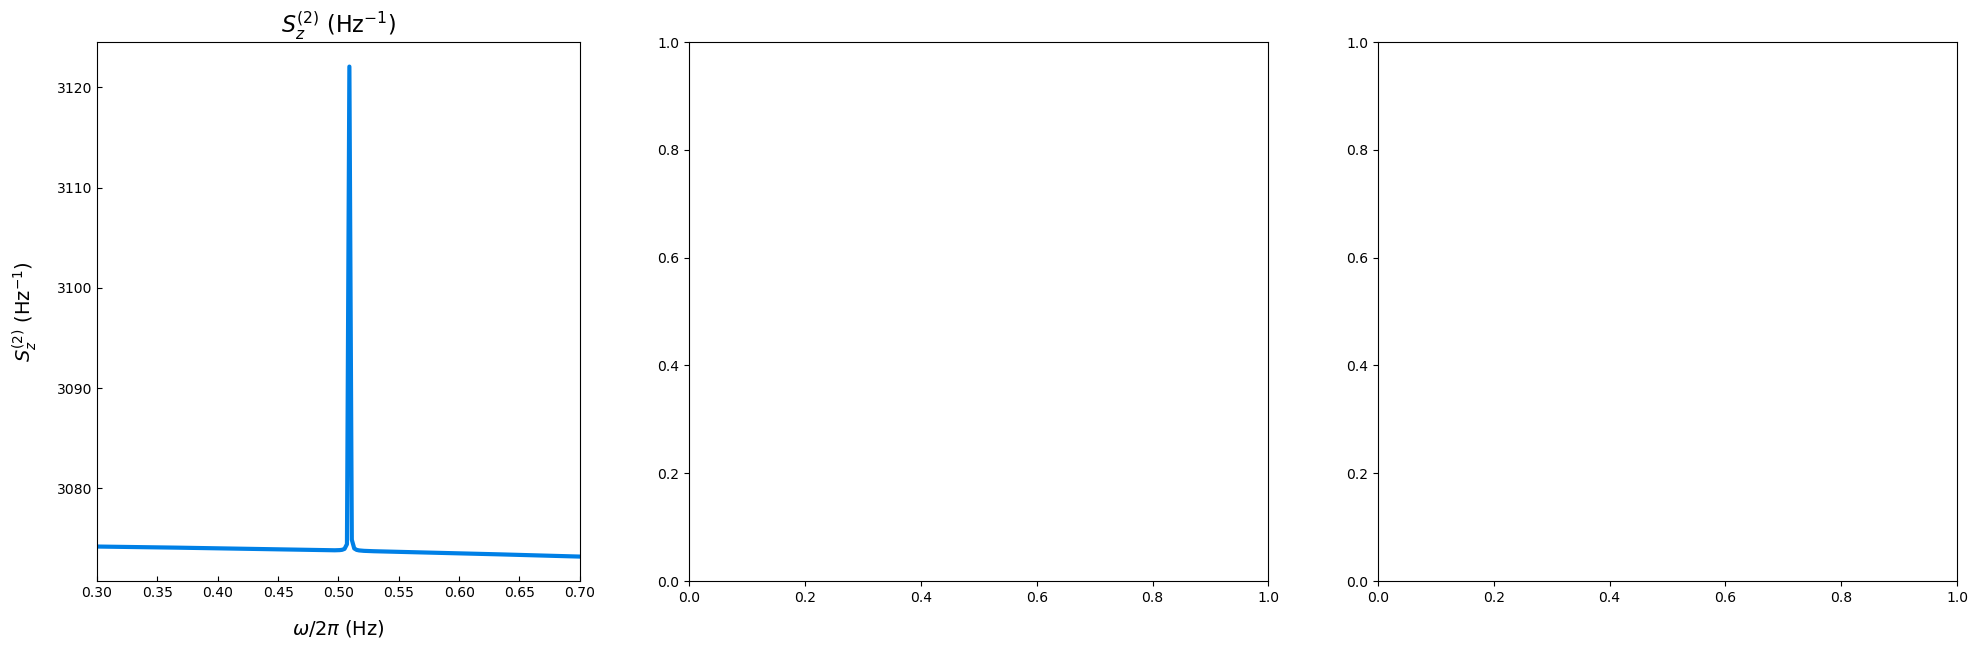

In [5]:
fig = system.plot()